In [1]:
# # 05 - Unsupervised Learning
# ## Clustering Analysis for Heart Disease Patterns
# 
# ### Objectives:
# - Apply K-Means clustering with elbow method
# - Perform hierarchical clustering with dendrogram
# - Compare clusters with actual disease labels

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
import joblib

In [5]:
# Load data
X_clean = pd.read_csv('data/heart_disease_cleaned_features.csv')
y_clean = pd.read_csv('data/heart_disease_cleaned_target.csv')['target']

print("Data loaded successfully!")

Data loaded successfully!


In [7]:
def perform_clustering_analysis(X, y):
    """Perform comprehensive clustering analysis"""
    
    # Use PCA for better visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    print("Clustering Analysis")
    print("=" * 50)
    
    # K-Means Clustering
    print("\n1. K-Means Clustering Analysis")
    
    # Elbow method to find optimal k
    wcss = []  # Within-cluster sum of squares
    k_range = range(2, 11)
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        wcss.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    # Find optimal k
    optimal_k = k_range[np.argmax(silhouette_scores)]
    
    # Plot elbow method and silhouette scores
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Elbow plot
    ax1.plot(k_range, wcss, 'bo-', linewidth=2)
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)')
    ax1.set_title('K-Means Elbow Method')
    ax1.grid(alpha=0.3)
    
    # Silhouette scores
    ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2)
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title(f'Silhouette Analysis (Optimal k = {optimal_k})')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Apply K-Means with optimal k
    kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_labels = kmeans_optimal.fit_predict(X)
    
    # Hierarchical Clustering
    print("\n2. Hierarchical Clustering Analysis")
    
    # Plot dendrogram
    plt.figure(figsize=(12, 6))
    # Use a sample for better visualization
    sample_indices = np.random.choice(X.shape[0], min(50, X.shape[0]), replace=False)
    X_sample = X.iloc[sample_indices]
    
    linkage_matrix = sch.linkage(X_sample, method='ward')
    dendrogram = sch.dendrogram(linkage_matrix, labels=sample_indices)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Apply hierarchical clustering with optimal k
    hierarchical = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
    hierarchical_labels = hierarchical.fit_predict(X)
    
    # Visualize clusters
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # K-Means visualization
    scatter1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
    axes[0, 0].set_xlabel('PC1')
    axes[0, 0].set_ylabel('PC2')
    axes[0, 0].set_title(f'K-Means Clustering (k={optimal_k})')
    plt.colorbar(scatter1, ax=axes[0, 0])
    
    # Hierarchical clustering visualization
    scatter2 = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='plasma')
    axes[0, 1].set_xlabel('PC1')
    axes[0, 1].set_ylabel('PC2')
    axes[0, 1].set_title(f'Hierarchical Clustering (k={optimal_k})')
    plt.colorbar(scatter2, ax=axes[0, 1])
    
    # True labels visualization
    scatter3 = axes[0, 2].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm')
    axes[0, 2].set_xlabel('PC1')
    axes[0, 2].set_ylabel('PC2')
    axes[0, 2].set_title('True Heart Disease Labels')
    plt.colorbar(scatter3, ax=axes[0, 2])
    
    # Cluster comparison with true labels
    # K-Means vs True labels
    kmeans_vs_true = pd.crosstab(pd.Series(kmeans_labels, name='K-Means'), 
                                pd.Series(y, name='True Label'))
    sns.heatmap(kmeans_vs_true, annot=True, fmt='d', cmap='YlOrBr', ax=axes[1, 0])
    axes[1, 0].set_title('K-Means vs True Labels')
    
    # Hierarchical vs True labels
    hierarchical_vs_true = pd.crosstab(pd.Series(hierarchical_labels, name='Hierarchical'), 
                                      pd.Series(y, name='True Label'))
    sns.heatmap(hierarchical_vs_true, annot=True, fmt='d', cmap='YlOrBr', ax=axes[1, 1])
    axes[1, 1].set_title('Hierarchical vs True Labels')
    
    # K-Means vs Hierarchical
    kmeans_vs_hierarchical = pd.crosstab(pd.Series(kmeans_labels, name='K-Means'), 
                                        pd.Series(hierarchical_labels, name='Hierarchical'))
    sns.heatmap(kmeans_vs_hierarchical, annot=True, fmt='d', cmap='YlOrBr', ax=axes[1, 2])
    axes[1, 2].set_title('K-Means vs Hierarchical')
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate clustering performance
    kmeans_silhouette = silhouette_score(X, kmeans_labels)
    hierarchical_silhouette = silhouette_score(X, hierarchical_labels)
    
    kmeans_ari = adjusted_rand_score(y, kmeans_labels)
    hierarchical_ari = adjusted_rand_score(y, hierarchical_labels)
    
    kmeans_nmi = normalized_mutual_info_score(y, kmeans_labels)
    hierarchical_nmi = normalized_mutual_info_score(y, hierarchical_labels)
    
    # Create results dataframe
    clustering_results = pd.DataFrame({
        'Method': ['K-Means', 'Hierarchical'],
        'Silhouette Score': [kmeans_silhouette, hierarchical_silhouette],
        'Adjusted Rand Index': [kmeans_ari, hierarchical_ari],
        'Normalized Mutual Info': [kmeans_nmi, hierarchical_nmi]
    }).round(4)
    
    print("\n3. Clustering Performance Metrics:")
    print("=" * 50)
    print(clustering_results)
    
    # Cluster analysis
    print("\n4. Cluster Characteristics:")
    print("=" * 50)
    
    # Add cluster labels to dataframe
    X_clustered = X.copy()
    X_clustered['KMeans_Cluster'] = kmeans_labels
    X_clustered['Hierarchical_Cluster'] = hierarchical_labels
    X_clustered['True_Label'] = y
    
    # Analyze cluster characteristics
    numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    
    print("\nK-Means Cluster Means (Numerical Features):")
    cluster_means = X_clustered.groupby('KMeans_Cluster')[numerical_features].mean()
    print(cluster_means.round(2))
    
    print("\nHierarchical Cluster Means (Numerical Features):")
    cluster_means_hier = X_clustered.groupby('Hierarchical_Cluster')[numerical_features].mean()
    print(cluster_means_hier.round(2))
    
    return (kmeans_optimal, hierarchical, clustering_results, 
            kmeans_labels, hierarchical_labels, X_clustered)

Clustering Analysis

1. K-Means Clustering Analysis


D:\apps\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\apps\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\apps\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\apps\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less 

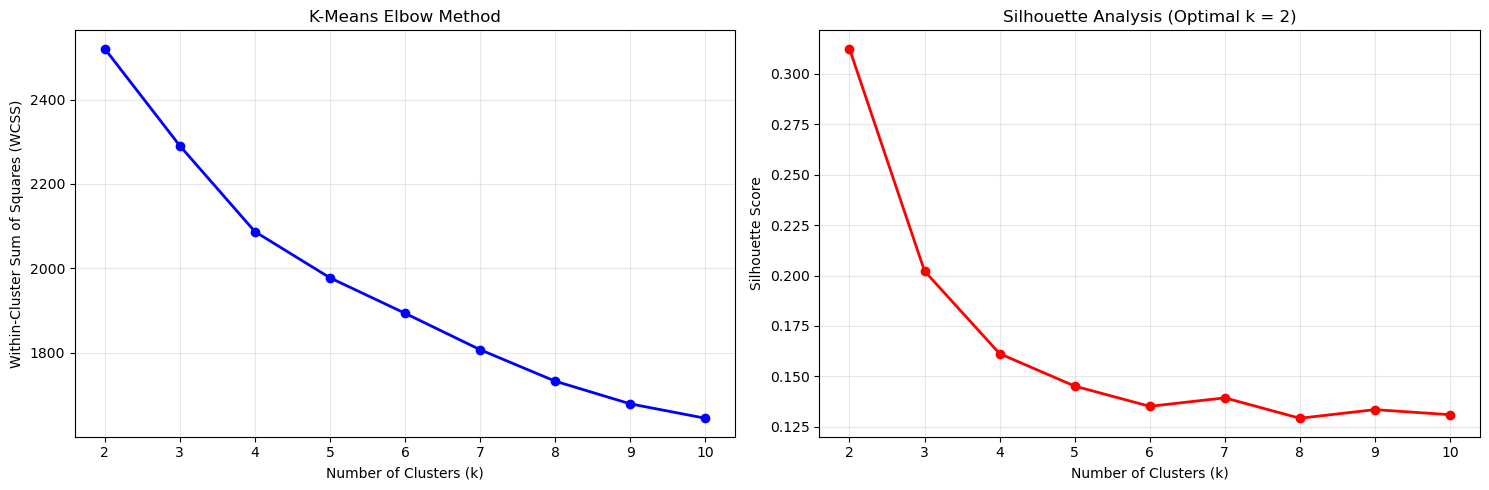

D:\apps\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(



2. Hierarchical Clustering Analysis


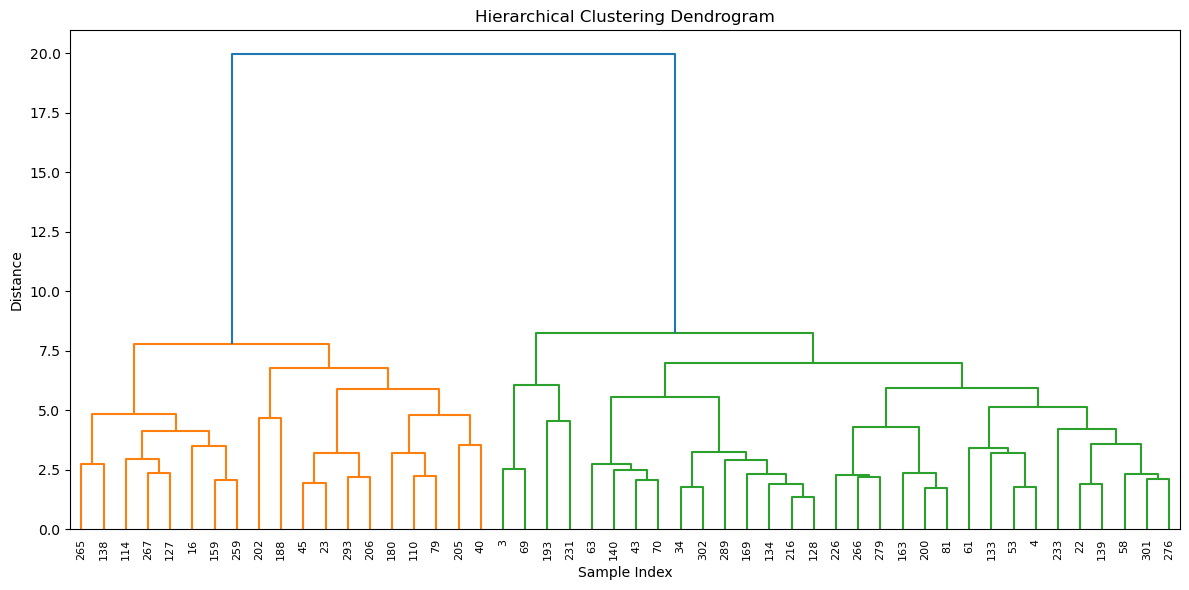

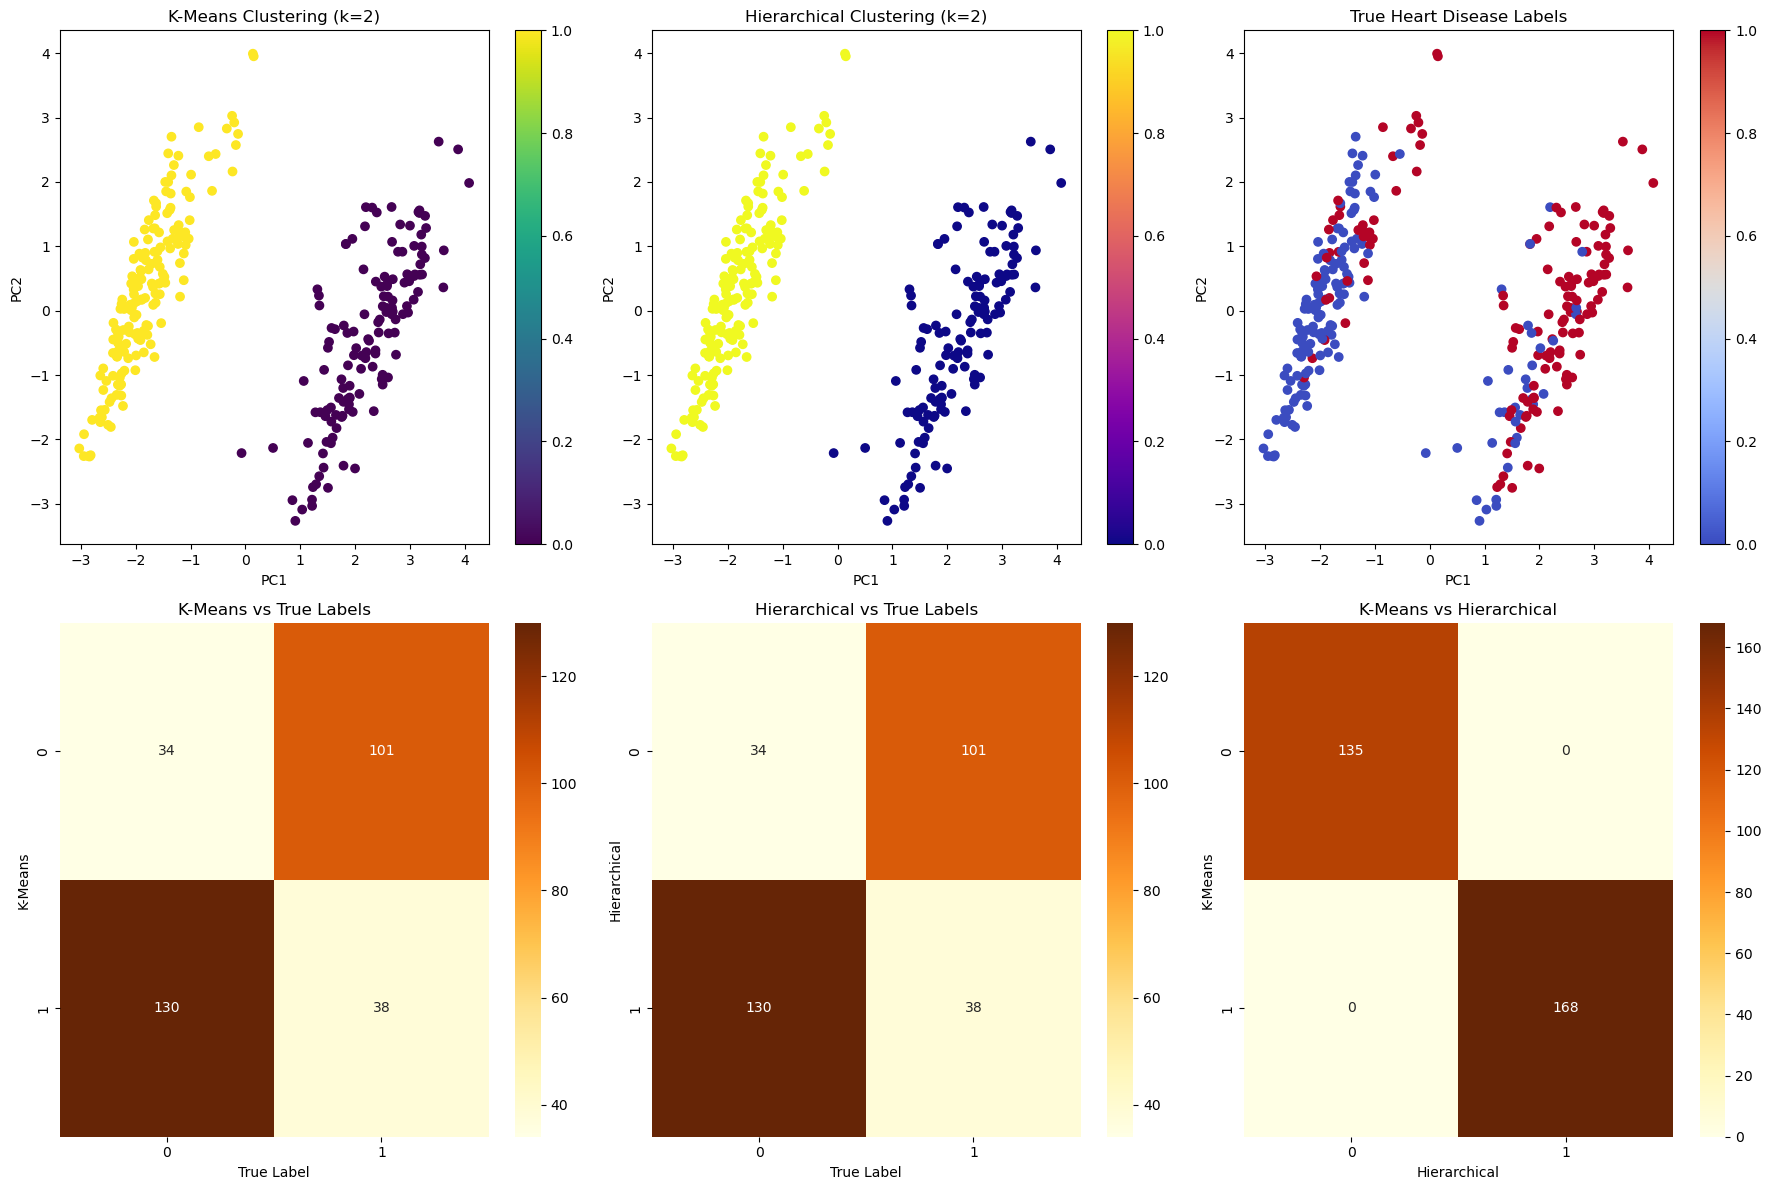


3. Clustering Performance Metrics:
         Method  Silhouette Score  Adjusted Rand Index  Normalized Mutual Info
0       K-Means            0.3123               0.2729                  0.2061
1  Hierarchical            0.3123               0.2729                  0.2061

4. Cluster Characteristics:

K-Means Cluster Means (Numerical Features):
                 age  trestbps  chol  thalach  oldpeak
KMeans_Cluster                                        
0               0.15      0.16  0.01    -0.32     0.39
1              -0.12     -0.13 -0.01     0.26    -0.31

Hierarchical Cluster Means (Numerical Features):
                       age  trestbps  chol  thalach  oldpeak
Hierarchical_Cluster                                        
0                     0.15      0.16  0.01    -0.32     0.39
1                    -0.12     -0.13 -0.01     0.26    -0.31


In [9]:
# Perform clustering analysis
kmeans_model, hierarchical_model, clustering_results, kmeans_labels, hierarchical_labels, X_clustered = perform_clustering_analysis(X_clean, y_clean)


In [11]:
# Save clustering results
clustering_info = {
    'kmeans_model': kmeans_model,
    'hierarchical_model': hierarchical_model,
    'kmeans_labels': kmeans_labels,
    'hierarchical_labels': hierarchical_labels,
    'clustering_results': clustering_results
}

joblib.dump(clustering_info, 'models/Unsupervised_clustering_models.pkl')
X_clustered.to_csv('data/heart_disease_clustered.csv', index=False)

print("\nUnsupervised learning completed! Results saved.")


Unsupervised learning completed! Results saved.
